In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, InputLayer

import matplotlib.pyplot as plt
import numpy as np

In [9]:
#data_generator=ImageDataGenerator(rescale=1.0/255, vertical_flip=True, zoom_range=0.2, rotation_range=30, width_shift_range=0.05, height_shift_range=0.05)
data_generator=ImageDataGenerator(rescale=1.0/255)

train_data_iterator = data_generator.flow_from_directory("Covid19-dataset/train", class_mode="categorical", color_mode="grayscale", target_size=(256,256), batch_size=2)
test_data_iterator = data_generator.flow_from_directory("Covid19-dataset/test", class_mode="categorical", color_mode="grayscale", target_size=(256,256), batch_size=2)

Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


In [10]:
#### BUILDING MODEL ####
model = Sequential()
model.add(InputLayer(input_shape=(256, 256, 1)))
model.add(Conv2D(32, 1, activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, 1, activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, 1, activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(3, activation='sigmoid'))
print(model.summary())
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=22)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=[tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.AUC()])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 256, 256, 32)      64        
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 64)      2112      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 128)       8320      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 32, 32, 128)     

In [12]:
#### TRAINING MODEL ####
test_steps_per_epoch = np.math.ceil(test_data_iterator.samples / test_data_iterator.batch_size)
train_steps_per_epoch = np.math.ceil(train_data_iterator.samples / train_data_iterator.batch_size)
history = model.fit(train_data_iterator, steps_per_epoch=train_steps_per_epoch, epochs=80, validation_data=test_data_iterator, validation_steps=test_steps_per_epoch, callbacks=[es])

Epoch 1/80
126/126 [==============================] - 17s 135ms/step - loss: 1.1211 - categorical_accuracy: 0.8207 - auc_1: 0.8799 - val_loss: 0.5936 - val_categorical_accuracy: 0.7424 - val_auc_1: 0.8738
Epoch 2/80
126/126 [==============================] - 14s 113ms/step - loss: 0.2848 - categorical_accuracy: 0.8884 - auc_1: 0.9576 - val_loss: 0.4968 - val_categorical_accuracy: 0.8333 - val_auc_1: 0.9195
Epoch 3/80
126/126 [==============================] - 17s 136ms/step - loss: 0.2084 - categorical_accuracy: 0.9283 - auc_1: 0.9719 - val_loss: 0.4587 - val_categorical_accuracy: 0.8939 - val_auc_1: 0.9412
Epoch 4/80
126/126 [==============================] - 18s 139ms/step - loss: 0.1882 - categorical_accuracy: 0.9482 - auc_1: 0.9759 - val_loss: 0.4088 - val_categorical_accuracy: 0.8485 - val_auc_1: 0.9537
Epoch 5/80
126/126 [==============================] - 19s 150ms/step - loss: 0.0874 - categorical_accuracy: 0.9602 - auc_1: 0.9915 - val_loss: 0.6769 - val_categorical_accuracy: 0.

33/33 - 1s - loss: 0.6251 - categorical_accuracy: 0.9242 - auc_1: 0.9382 - 732ms/epoch - 22ms/step
0.9242424368858337


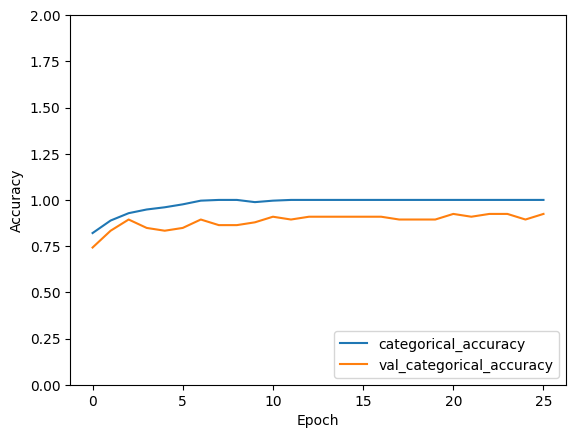

In [13]:
plt.plot(history.history['categorical_accuracy'], label='categorical_accuracy')
plt.plot(history.history['val_categorical_accuracy'], label = 'val_categorical_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 2])
plt.legend(loc='lower right')

test_loss, test_acc, test_auc = model.evaluate(test_data_iterator, verbose=2)
print(test_acc)


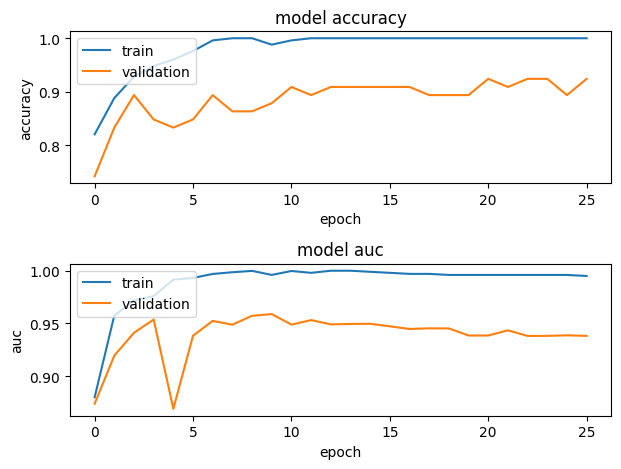

In [16]:
fig = plt.figure()
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(history.history['categorical_accuracy'])
ax1.plot(history.history['val_categorical_accuracy'])
ax1.set_title('model accuracy')
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax1.legend(['train', 'validation'], loc='upper left')
 
# plotting auc and validation auc over epochs
ax2 = fig.add_subplot(2, 1, 2)
ax2.plot(history.history['auc_1'])
ax2.plot(history.history['val_auc_1'])
ax2.set_title('model auc')
ax2.set_xlabel('epoch')
ax2.set_ylabel('auc')
ax2.legend(['train', 'validation'], loc='upper left')
 
# used to keep plots from overlapping
fig.tight_layout()
plt.show()

In [17]:
predictions = model.predict(test_data_iterator, steps=test_steps_per_epoch)
predicted_classes = np.argmax(predictions, axis=1)
test_steps_per_epoch = np.math.ceil(test_data_iterator.samples / test_data_iterator.batch_size)
true_classes = test_data_iterator.classes
print(true_classes)
class_labels = list(test_data_iterator.class_indices.keys())
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)   
 
cm=confusion_matrix(true_classes,predicted_classes)
print(cm)

33/33 [==============================] - 1s 21ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
              precision    recall  f1-score   support

       Covid       0.32      0.35      0.33        26
      Normal       0.23      0.25      0.24        20
   Pneumonia       0.25      0.20      0.22        20

    accuracy                           0.27        66
   macro avg       0.27      0.27      0.26        66
weighted avg       0.27      0.27      0.27        66

[[ 9 10  7]
 [10  5  5]
 [ 9  7  4]]
